In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import string
import time
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = os.path.join(os.getcwd(), "Dataset", "titanic dataset")
PATH = os.path.join(DATA_DIR, "train_data_v1.csv")

In [3]:
df = pd.read_csv(PATH)

In [5]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Ticket,Cabin,Embarked,Name,Cabin_ticket_list,Cabin_seat_count,Cabin_group,Family_Member_Count,Sex_encoded,Cabin_encoded,Cabin_group_encoded,Embarked_encoded
0,1,0,3,22.0,1,0,7.2500,male,A/5 21171,Missing,S,"['braund', 'mr', 'owen', 'harris']",[],0,M,1,1,146,7,2
1,2,1,1,38.0,1,0,71.2833,female,PC 17599,C85,C,"['cumings', 'mrs', 'john', 'bradley', 'florenc...",['C85'],1,C,1,0,81,2,0
2,3,1,3,26.0,0,0,7.9250,female,STON/O2. 3101282,Missing,S,"['heikkinen', 'miss', 'laina']",[],0,M,0,0,146,7,2
3,4,1,1,35.0,1,0,53.1000,female,113803,C123,S,"['futrelle', 'mrs', 'jacques', 'heath', 'lily'...",['C123'],1,C,1,0,55,2,2
4,5,0,3,35.0,0,0,8.0500,male,373450,Missing,S,"['allen', 'mr', 'william', 'henry']",[],0,M,0,1,146,7,2


## Handeling Outliers

### Numerical Variable

In [15]:
from scipy import stats
# tes of normality
def check_normality(data):
    stat, p_value = stats.shapiro(data)
    h_0 = "H0: data normally distributed"
    h_1 = "H1: data not normally distributed"
    result = ""
    if p_value < 0.05:
        result = "Reject null hypothesis"
    else:
        result = "Fail to reject null hypothesis"

    return {"h0":h_0, "h1":h_1,"p_val":p_value, "cc":result}

In [16]:
def plot_hist(df, col, max_):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    df_dict=check_normality(df[col])
    df_hypo_title = "{}\n{}\np-value:{} alpha: 0.05\n Result: {}".format(df_dict["h0"],
                                                                            df_dict["h1"],
                                                                            df_dict["p_val"],
                                                                            df_dict["cc"])

    fig.suptitle(df_hypo_title)

    sm.qqplot(df[col], line='45', ax=axs[0])
    axs[0].set_title("Q-Q Plot")
    df[col].plot(kind="kde", ax=axs[1])
    axs[1].vlines(ymin=0,ymax=max_,x=df[col].mean(), color="red",label="Mean")
    axs[1].vlines(ymin=0,ymax=max_,x=df[col].median(), color="green",label="Median")
    axs[1].set_xlabel(col)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### Age

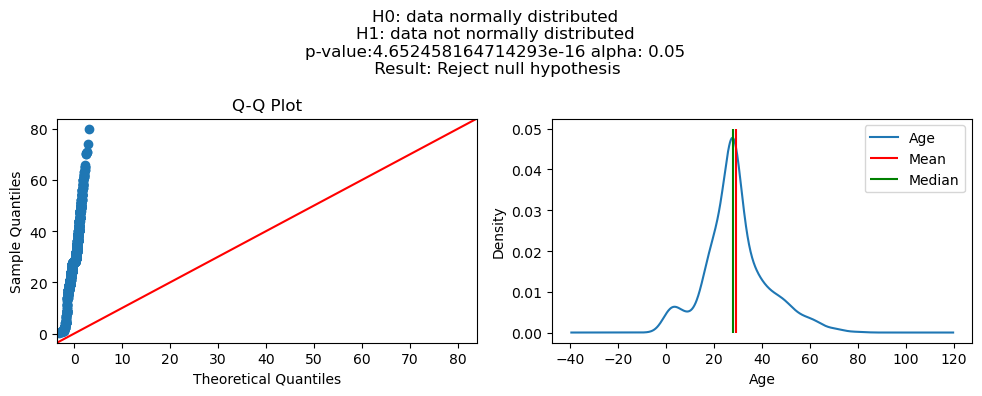

In [17]:
plot_hist(df, "Age", 0.05)

- there are outliers in age 
- it is right skewed

#### Handeling Skewness of data : Age

##### 1. Log Transfromation

In [18]:
# 1. Log Transfromation
df["Age_logged"] =np.log(df["Age"])

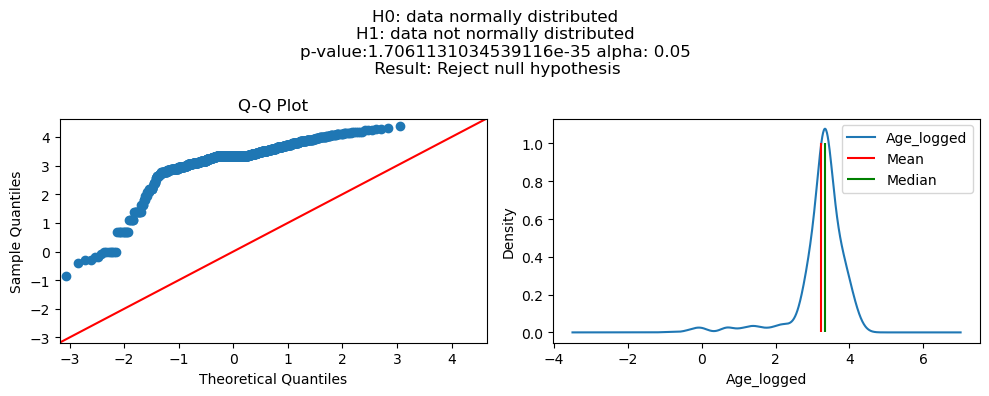

In [22]:
plot_hist(df, "Age_logged", 1)

##### 2. Square root transformation

In [20]:
# 2. Square root transformation
df["Age_sqrt"] =np.sqrt(df["Age"])

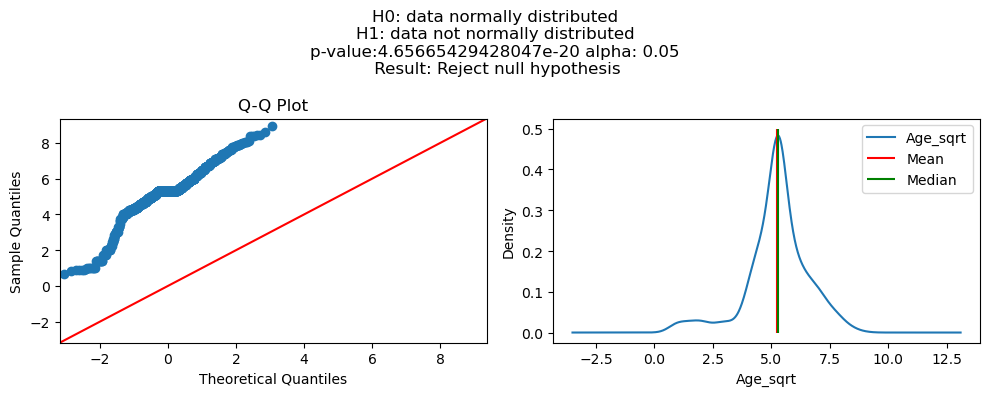

In [23]:
plot_hist(df, "Age_sqrt", 0.5)

In [24]:
from scipy.stats import boxcox
df["Age_boxcox"], lambda_value = boxcox(df["Age"])

##### 3. Box-Cox Transformation

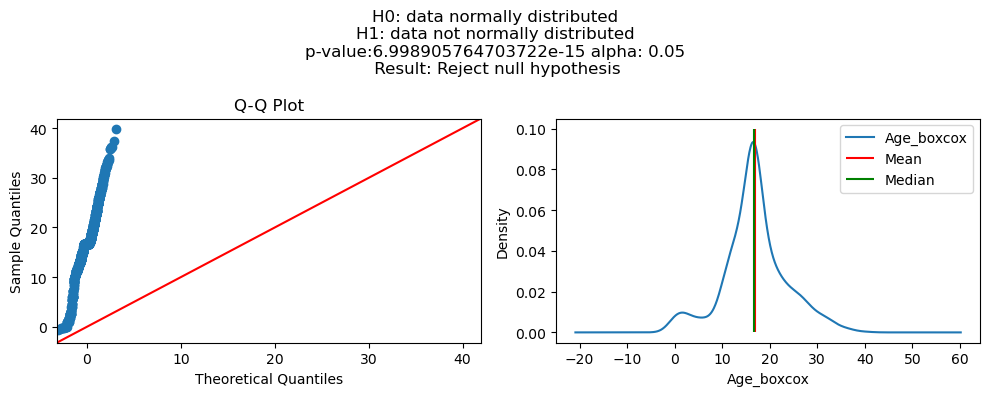

In [26]:
# 3. Box-Cox Transformation
plot_hist(df, "Age_boxcox", 0.1)

##### 4. Yeo-Johnson Transformation

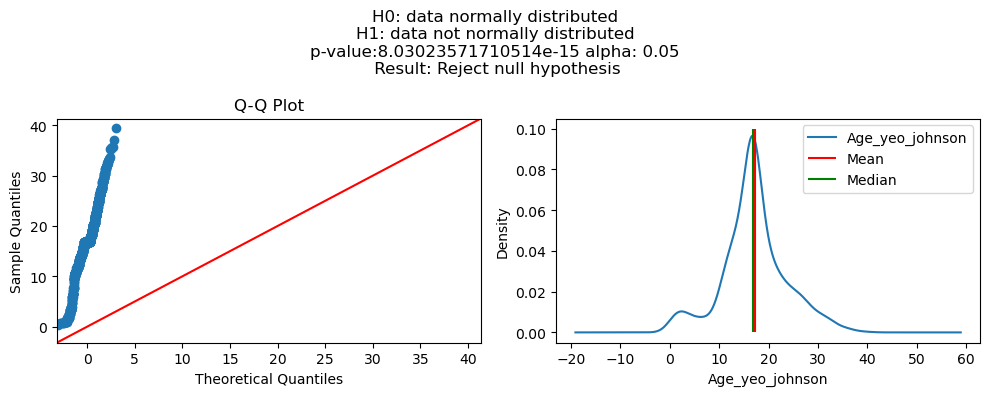

In [27]:
from scipy.stats import yeojohnson
df["Age_yeo_johnson"], lambda_value = yeojohnson(df["Age"])
plot_hist(df, "Age_yeo_johnson", 0.1)

##### 5. Square Transformation

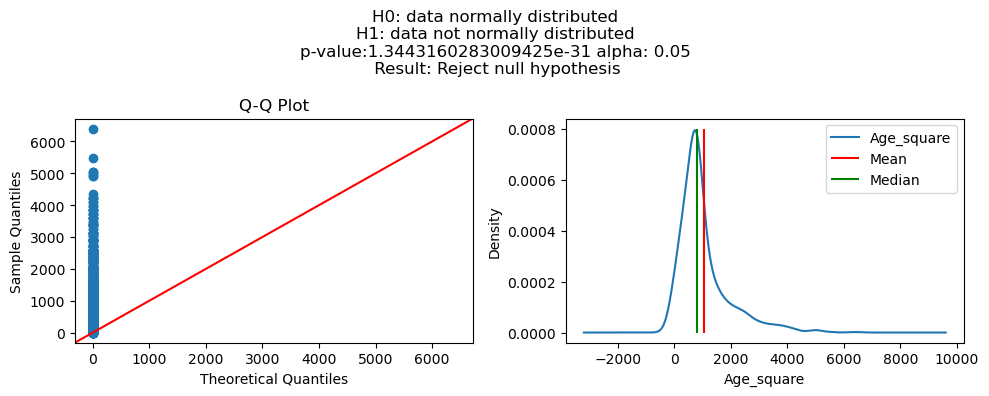

In [34]:
df["Age_square"] = np.square(df["Age"])
plot_hist(df, "Age_square", 0.0008)

##### 6. Cube Transformation

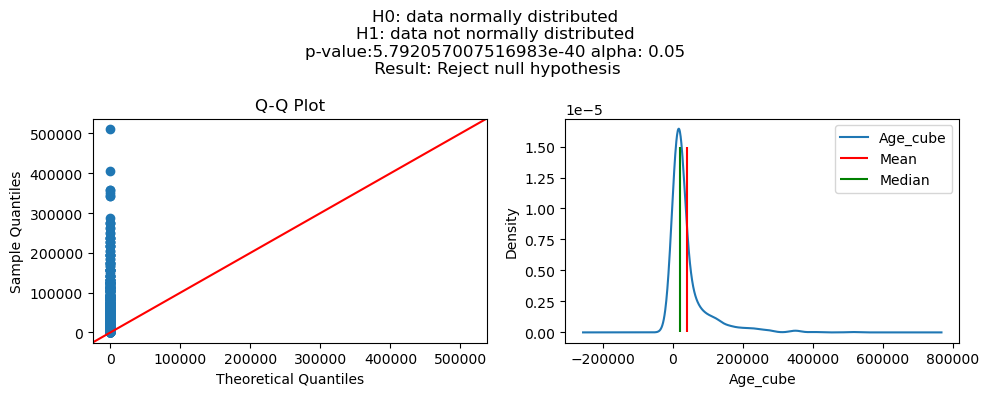

In [40]:
df["Age_cube"] = np.power(df["Age"], 3)
plot_hist(df, "Age_cube", 0.0000150)

##### 7. Scaling and Centering

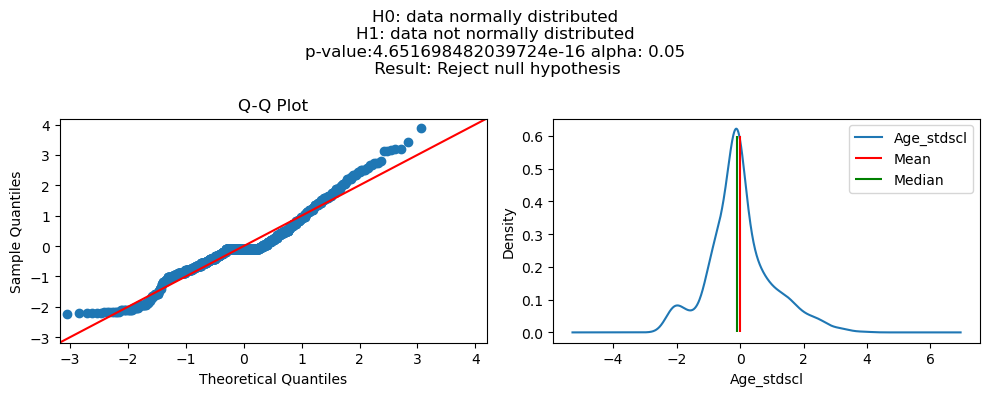

In [68]:
from sklearn.preprocessing import StandardScaler
std_scl = StandardScaler()

age_data = df["Age"].iloc[:].values

df["Age_stdscl"] = std_scl.fit_transform(age_data.reshape(-1,1))

plot_hist(df, "Age_stdscl", 0.6)

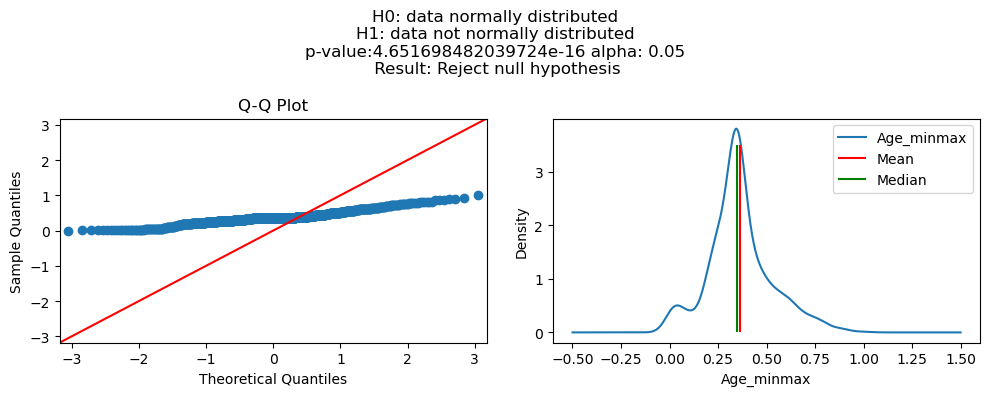

In [71]:
from sklearn.preprocessing import MinMaxScaler
mm_scl = MinMaxScaler()

age_data = df["Age"].iloc[:].values

df["Age_minmax"] = mm_scl.fit_transform(age_data.reshape(-1,1))

plot_hist(df, "Age_minmax", 3.5)

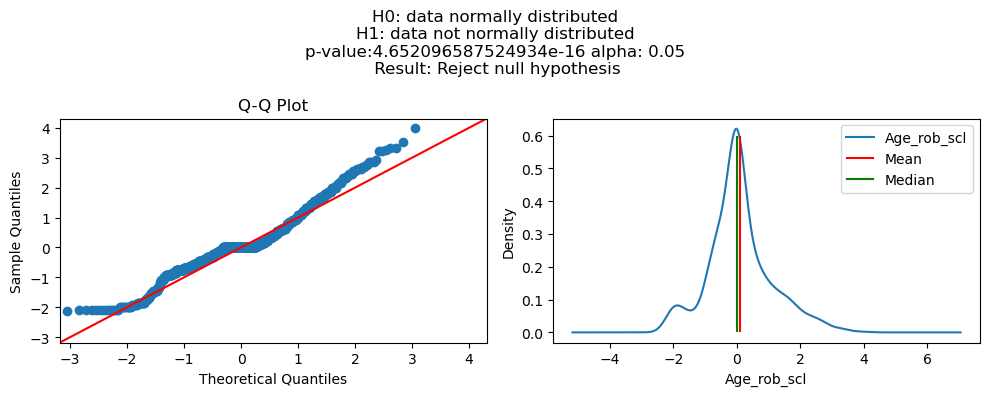

In [74]:
from sklearn.preprocessing import RobustScaler
rob_scl = RobustScaler()

age_data = df["Age"].iloc[:].values

df["Age_rob_scl"] = rob_scl.fit_transform(age_data.reshape(-1,1))

plot_hist(df, "Age_rob_scl", 0.6)

##### 8. Non-parametric Methods

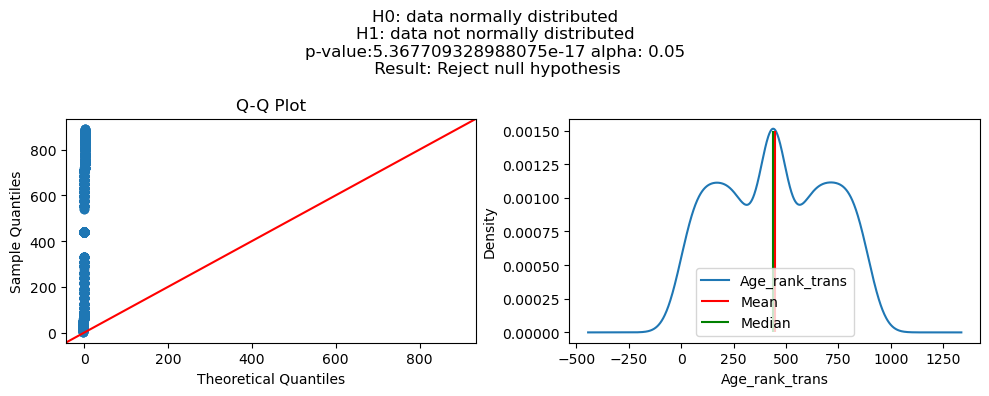

In [79]:
from scipy.stats import rankdata
df["Age_rank_trans"] = rankdata(df["Age"])
plot_hist(df, "Age_rank_trans", 0.00150)

##### 9. Remove Outliers

###### 1. Z-Score Method

In [85]:
from scipy import stats
z_scores = np.abs(stats.zscore(df["Age"]))
threshold = 3
outliers = np.where(z_scores > threshold)


In [103]:
outliers_df = df.drop(outliers)

ValueError: Index data must be 1-dimensional

In [102]:
# Identify outlier rows
outlier_rows = np.any(z_scores > threshold, axis=1)

# Remove outliers
clean_df = df.drop(outlier_rows)

ValueError: No axis named 1 for object type Series

In [97]:
# df[(z_scores < threshold).all(axis=0)]

In [82]:
outliers

(array([ 96, 116, 493, 630, 672, 745, 851]),)

###### 2. IQR Method

In [ ]:
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = np.where((data < lower_bound) | (data > upper_bound))
clean_data = data[(data >= lower_bound) & (data <= upper_bound)]